In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy


original_df = pd.read_csv("/content/drive/MyDrive/Vezilka/people.csv")
original_df = original_df.dropna(subset=[
    "personLabel","genderLabel","birthPlaceLabel",
    "occupationLabel","educationLabel","birthDate"
]).reset_index(drop=True)

final_df = pd.read_csv("/content/drive/MyDrive/Vezilka/all_people_with_bios.csv")

synthetic_only = final_df[final_df["source"] == "synthetic"].reset_index(drop=True)


**Duplication rate**

In [11]:
total = len(synthetic_only)
unique_bios = synthetic_only["biography"].nunique()
dup_rate = 1 - (unique_bios / total)
print(f"Duplication rate (synthetic only): {dup_rate:.2%}")

Duplication rate (synthetic only): 0.00%


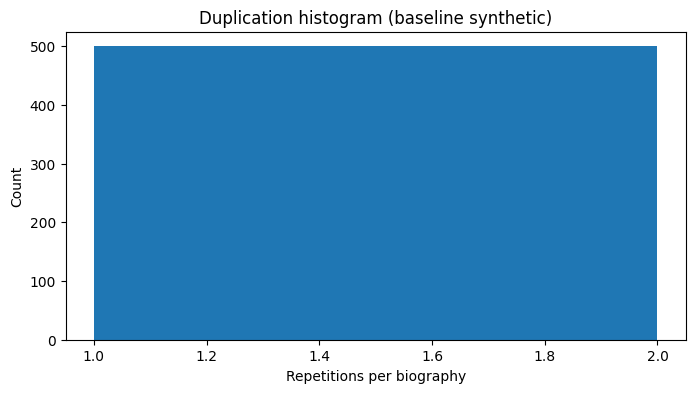

In [12]:
# Histogram на duplication (број на биографии кои се exact duplicates)
bio_counts = synthetic_only["biography"].value_counts()
plt.figure(figsize=(8,4))
plt.hist(bio_counts.values, bins=range(1, bio_counts.max()+2))
plt.title("Duplication histogram (baseline synthetic)")
plt.xlabel("Repetitions per biography")
plt.ylabel("Count")
plt.show()


**Diversity**

In [13]:
for col in ["occupationLabel", "educationLabel", "birthPlaceLabel"]:
    print(f"\n{col}")
    print("Synthetic (top 10):")
    print(synthetic_only[col].value_counts().head(10))
    print("\nOriginal (top 10):")
    print(original_df[col].value_counts().head(10))


occupationLabel
Synthetic (top 10):
occupationLabel
театарски глумец           16
музички продуцент          12
универзитетски професор    11
книжевен научник           11
автор                      10
театролог                  10
дипломат                   10
политиколог                10
публицист                  10
сликар                      9
Name: count, dtype: int64

Original (top 10):
occupationLabel
писател                    88
политичар                  69
поет                       39
универзитетски професор    25
новинар                    24
економист                  17
дипломат                   17
книжевен критичар          16
преведувач                 15
драматург                  10
Name: count, dtype: int64

educationLabel
Synthetic (top 10):
educationLabel
Белградски универзитет    20
Q4722573                  17
Универзитет во Љубљана    17
Q1346135                  16
Q1109135                  16
Q7592124                  16
Q14701409                 16
Q4864

**Realism**

In [14]:
orig_combos = set(tuple(x) for x in original_df[
    ["occupationLabel","educationLabel"]
].values)

synth_combos = set(tuple(x) for x in synthetic_only[
    ["occupationLabel","educationLabel"]
].values)

overlap = len(orig_combos & synth_combos)
print(f"\nCombination overlap (occupation+education): {overlap}/{len(synth_combos)}")


Combination overlap (occupation+education): 26/469


**KL divergence / similarity**

In [15]:
def kl_divergence(p, q):
    p = p / p.sum()
    q = q / q.sum()
    q = q.replace(0, 1e-10)
    return entropy(p, q)

for col in ["occupationLabel", "educationLabel", "birthPlaceLabel"]:
    p = original_df[col].value_counts()
    q = synthetic_only[col].value_counts()
    idx = p.index.union(q.index)
    kl = kl_divergence(p.reindex(idx, fill_value=0),
                       q.reindex(idx, fill_value=0))
    print(f"KL divergence ({col}): {kl:.4f}")

KL divergence (occupationLabel): 1.3442
KL divergence (educationLabel): 1.7538
KL divergence (birthPlaceLabel): 1.0700


**Logical consistency checks**

In [16]:
# Birth < Death
death_invalid = synthetic_only[
    synthetic_only["deathDate"].notna() &
    (pd.to_datetime(synthetic_only["deathDate"]) <
     pd.to_datetime(synthetic_only["birthDate"]))
]
print(f"\nInvalid deathDate < birthDate: {len(death_invalid)}")

# Gender suffix
rod_mismatch = synthetic_only[
    (synthetic_only["genderLabel"].str.startswith("ж")) &
    (~synthetic_only["biography"].str.contains("родена"))
]
print(f"Gender suffix mismatches: {len(rod_mismatch)}")


Invalid deathDate < birthDate: 0
Gender suffix mismatches: 164
